# TD 2 - Computational Statistics - MVA 23-24
### Meilame TAYEBJEE

In [1]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from scipy.special import logsumexp
import pandas as pd

## Exercise 1: Discrete distributions

In [2]:
def generateDistrib(p, x, N = 1):
    """
    Args:
        p (list or array shape (1,n)): list of probabilities
        x (list or array shape (1,n)): list of sorted values
        N (int): number of values to generate
        
    Returns
        (list): list of N values x generated according to the distribution p
    """

    u = np.random.rand(N)
    P = np.cumsum(p)
    res = []
    for i in range(N):
        res.append(x[np.where(P-u[i] > 0)[0][0]]) # appends x[i] where i is the first index where P-u[i] > 0 ie P[i-1] < u[i] < P[i]
    return res


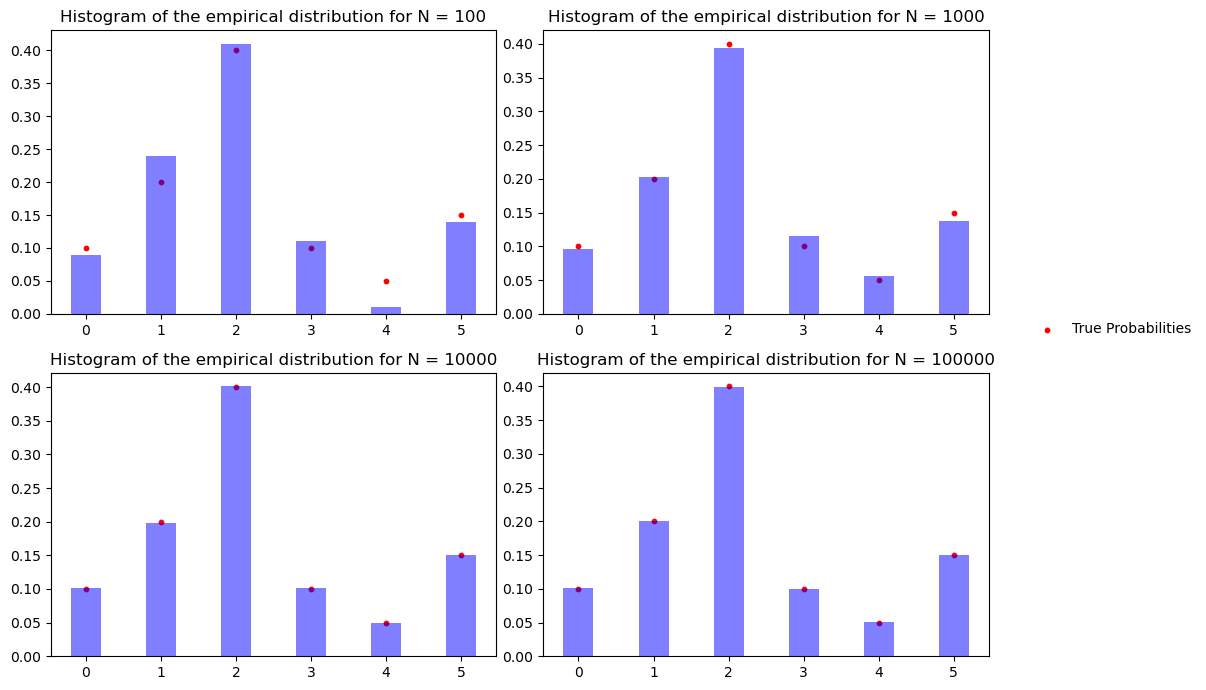

In [3]:
#---------INPUTS-------------#
p = [0.1, 0.2, 0.4, 0.1, 0.05, 0.15] # Probabilities
x = range(6) # Values
#----------------------------#

Ns = [100, 1000, 10000, 100000] #We make vary the number of simulations

fig = plt.figure(figsize=(10, 7))
for N in Ns:
    plt.subplot(2,2,Ns.index(N)+1)
    plt.hist(generateDistrib(p, x, N), density = True, bins = range(7), rwidth = 0.4, align = 'left', alpha = 0.5, color = 'b')
    plt.scatter(x, p, color = 'red', s = 10, label = "True probabilities")
    plt.title("Histogram of the empirical distribution for N = {}".format(N))

fig.legend(['True Probabilities'], bbox_to_anchor=(1.2, 0.55), frameon = False)
plt.tight_layout()
plt.show()

## Exercise 2: GMM and the EM algorithm

### GMM generation and visualization

In [4]:
def generateGMM(alphas, mus, Sigmas, N = 1):
    """
    Args:
        alphas (list or array shape (1,p)): list of probabilities, p being the number of clusters
        mus (list or array shape (p,d = 2)): list of means
        Sigmas (array shape (d,d,p)): list of covariance matrices
        N (int): number of samples to generate

    Returns
        (list): list of N values x generated according to the GMM model
        (list): list of N values z generated according to the GMM model (the cluster assignements) (which are not supposed to be observed)
    """

    p = len(alphas) #number of clusters
    clusters_assignment = generateDistrib(alphas, range(p), N) #assigns each sample to a cluster ; basically contains z1...zN. We use the exercise 1 function
    res = []
    for i in range(N):
        #generation of x_i according to the multivariate normal distribution (mu_[z_i], Sigma_[z_i])
        res.append(np.random.multivariate_normal(mus[clusters_assignment[i]], Sigmas[:,:,clusters_assignment[i]])) 

    return res, clusters_assignment

---- CLUSTER 1 ----
Mean :  [0, 0]
Covariance matrix :  [[3.55035703 0.38771845]
 [0.38771845 3.90450574]]
Expected proportion of samples (alpha_0) :  0.1

---- CLUSTER 2 ----
Mean :  [10, 10]
Covariance matrix :  [[5.27985658 1.12422   ]
 [1.12422    3.60560567]]
Expected proportion of samples (alpha_1) :  0.45

---- CLUSTER 3 ----
Mean :  [0, 10]
Covariance matrix :  [[6.29861554 2.56764763]
 [2.56764763 5.05347884]]
Expected proportion of samples (alpha_2) :  0.3

---- CLUSTER 4 ----
Mean :  [10, 0]
Covariance matrix :  [[10.61143748  1.13391759]
 [ 1.13391759  4.81758809]]
Expected proportion of samples (alpha_3) :  0.15



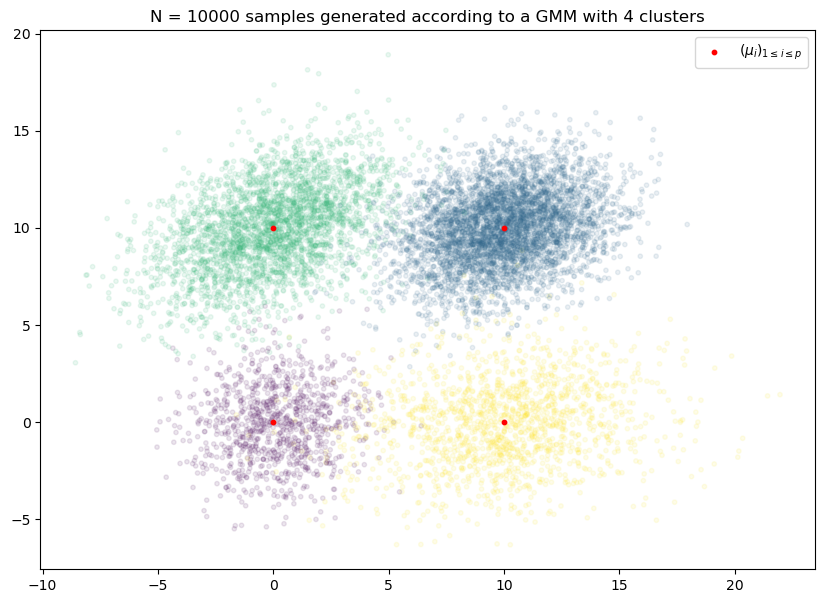

In [5]:
p = 4 #Number of clusters
alphas = [0.1, 0.45, 0.3, 0.15] #P(z) (parameters of the multinomial distribution)

if sum(alphas) != 1:
    raise ValueError("The sum of the probabilities must be equal to 1")


mus = [[0,0], [10,10], [0,10], [10,0]] #Means of the clusters
N = 10000 #Number of simulations

reg = 3 #Regularization parameter (Sigma = A.T @ A + reg*I)

Sigmas = np.zeros((2,2,p))
for i in range(p):
    A = (i+1)*np.random.rand(2,2)  #A is a random matrix
    Sigmas[:,:,i] = A.T @ A + reg*np.eye(2) #Covariance matrices of the clusters, positive definite
    print("---- CLUSTER {} ----".format(i+1))
    print("Mean : ", mus[i])
    print("Covariance matrix : ", Sigmas[:,:,i])
    print("Expected proportion of samples (alpha_{}) : ".format(i), alphas[i])
    print("")


X, Z = generateGMM(alphas, mus, Sigmas, N)

plt.figure(figsize=(10, 7))

scatter = plt.scatter([x[0] for x in X], [x[1] for x in X], s = 10, alpha = 0.1, c=Z, cmap='viridis')
plt.scatter([mus[i][0] for i in range(p)], [mus[i][1] for i in range(p)], color = 'red', s = 10, label = "$(\mu_i)_{1 \leq i \leq p}$")
plt.legend()
plt.title("N = {} samples generated according to a GMM with {} clusters".format(N, p))
plt.show()

### EM Algorithm

In [6]:
def EM_Algorithm(X, p,  alphas_init, mus_init, Sigmas_init,Niter = 100, eps = 1e-2, reg = 1e-6, verbose = False):
    """
    Args:
        X (array shape (N,d)): list/array of N samples
        alphas_init (list or array shape (1,p)): initialization of the estimator of alpha
        mus_init (list or array shape (p,d)): initialization of the estimator of alpha
        Sigmas_init (array shape (d,d,p)): initialization of the estimator of Sigmas^-1
        Niter (int): number of iterations max
        eps (float): tolerance parameter

    Returns
        (list), size Niter: list of log-likelihoods over the iterations
        (list), size Niter: list of the estimator of alphas over the iterations
        (list), size Niter: list of the estimator of mus over the iterations
        (list), size Niter: list of the estimator of Sigmas over the iterations
    """

    np.random.seed(0)
    X = np.array(X)
    N, d = X.shape


    #These will always contain the "last" estimator of alphas, mus and Sigmas (Theta^t)
    alphas = alphas_init 
    mus = mus_init
    Sigmas = Sigmas_init

    #These will contain the estimators of alphas, mus and Sigmas and also the responsabilities (posterior of z) over the iterations
    all_alphas = [alphas]
    all_mus = [mus]
    all_Sigmas = [Sigmas]
    all_taus = []
    
    #This will contain the log-likelihoods over the iterations
    log_likelihoods = []

    for iter in range(Niter):
        if verbose:
            print("Iteration {}".format(iter+1))
            if iter > 0:
                print("Log Likelihood : ", log_likelihoods[-1])


        #E-step (update of tau)
        tau = np.zeros((N,p)) #responsabilities
        for j in range(p):
            tau[:,j] = alphas[j]*stats.multivariate_normal.pdf(X, mus[j], Sigmas[:,:,j])

        normalizer = np.sum(tau, axis = 1) #shape (N,). The "denominator"

        log_likelihoods.append(np.sum(np.log(normalizer))) #The log likelihood is the sum of the log of the denominator of the posterior of z

        for j in range(p):
            tau[:,j] /= normalizer

        all_taus.append(tau)

        #M-step
        alphas = np.sum(tau, axis = 0)/N
        mus = tau.T @ X/np.sum(tau, axis = 0)[:,None]
        for k in range(p):
            Sigmas[:,:,k] = np.sum([tau[n,k]*np.outer(X[n]-mus[k], X[n]-mus[k]) for n in range(N)], axis = 0)/np.sum(tau[:,k])
            Sigmas[:,:,k] += reg*np.eye(2)

        all_alphas.append(alphas)
        all_mus.append(mus)
        all_Sigmas.append(Sigmas)

        #Stopping criterion
        if iter > 2 and abs(log_likelihoods[-1] - log_likelihoods[-2]) < eps:
            break

    return log_likelihoods, all_alphas, all_mus, all_Sigmas, all_taus

Iteration 1
Iteration 2
Log Likelihood :  -68461.30503403464
Iteration 3
Log Likelihood :  -58755.34280541343
Iteration 4
Log Likelihood :  -58164.00195867866
Iteration 5
Log Likelihood :  -57929.034307106136
Iteration 6
Log Likelihood :  -57814.284188478996
Iteration 7
Log Likelihood :  -57731.74256110941
Iteration 8
Log Likelihood :  -57654.08987617644
Iteration 9
Log Likelihood :  -57565.84288855632
Iteration 10
Log Likelihood :  -57452.38538449108
Iteration 11
Log Likelihood :  -57311.39472356997
Iteration 12
Log Likelihood :  -57168.749930422884
Iteration 13
Log Likelihood :  -57054.19963130985
Iteration 14
Log Likelihood :  -56980.443438457034
Iteration 15
Log Likelihood :  -56934.57703502841
Iteration 16
Log Likelihood :  -56897.71109994517
Iteration 17
Log Likelihood :  -56861.47028013469
Iteration 18
Log Likelihood :  -56823.14513966233
Iteration 19
Log Likelihood :  -56781.31823380306
Iteration 20
Log Likelihood :  -56734.66463034638
Iteration 21
Log Likelihood :  -56681.7697

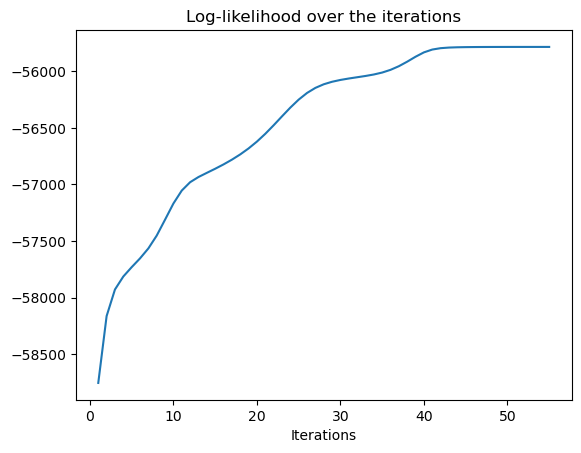

True alphas :  [0.1  0.15 0.3  0.45]
Estimated alphas :  [0.09940353 0.15148675 0.3033122  0.44579751]

True mus :  [[ 0  0]
 [10  0]
 [ 0 10]
 [10 10]]
Estimated mus :  [[ 0.18505018 -0.11577252]
 [10.08946623 -0.06601982]
 [-0.04766518  9.9689129 ]
 [ 9.97786774  9.97841498]]


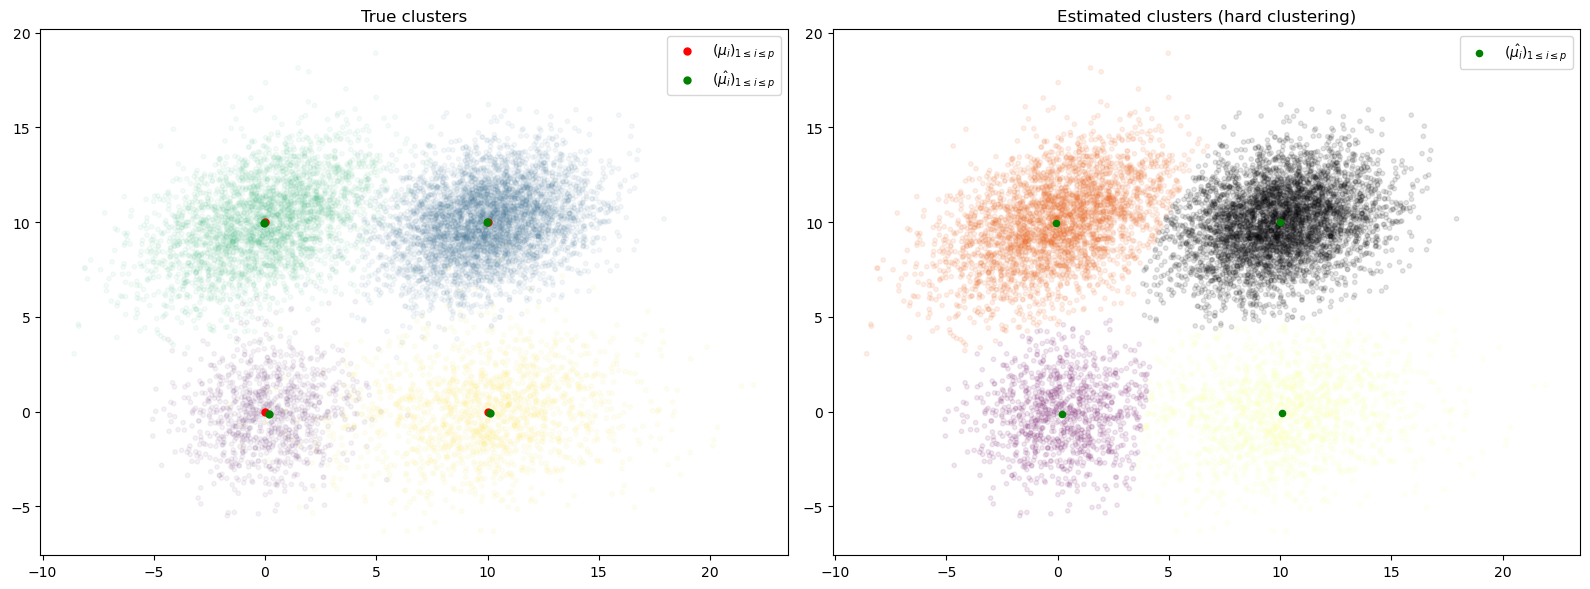

In [7]:
#Initialization of the parameters
d= 2
alphas_init = [1/p]*p 
X = np.array(X)
mus_init = X[np.random.choice(N, p, replace=False)]
Sigmas_init = np.zeros((d,d,p))
for j in range(p):
    Sigmas_init[:,:,j] = np.eye(d) * np.mean(np.var(X, axis=0) / p)

#------EM ALGORITHM------#
log_likelihoods, all_alphas, all_mus, all_Sigmas, all_taus = EM_Algorithm(X, 4, alphas_init, mus_init, Sigmas_init, reg = 0, verbose=True, Niter=100)
plt.plot(range(1, len(log_likelihoods)), log_likelihoods[1:])
plt.title("Log-likelihood over the iterations")
plt.xlabel("Iterations")
plt.show()

predicted_alphas = all_alphas[-1]
predicted_mus = all_mus[-1]
predicted_Sigmas = all_Sigmas[-1]
predicted_taus = all_taus[-1]

hard_clustering = np.argmax(predicted_taus, axis = 1) #hard clustering: tau_{i,j} = P(z = j | x_i) so we take the argmax over j (the most likely cluster) for each sample i

pred_alpha_to_mu = {predicted_alphas[i]:predicted_mus[i] for i in range(p)} #dictionary that associates each alpha to its corresponding mu
alphas_to_mu = {alphas[i]:mus[i] for i in range(p)} #dictionary that associates each alpha to its corresponding mu

alphas = np.sort(alphas)
predicted_alphas = np.sort(predicted_alphas)
mus = np.array([alphas_to_mu[alpha] for alpha in alphas])
predicted_mus = np.array([pred_alpha_to_mu[alpha] for alpha in predicted_alphas])

#------ ALPHAS------#
print("True alphas : ", alphas)
print("Estimated alphas : ", predicted_alphas)
print("")

#------ MUS------#
print("True mus : ", mus)
print("Estimated mus : ", predicted_mus)


#------Plot estimated clusters------#
fig = plt.figure(figsize=(16, 6))
plt.subplot(1,2,1)
plt.scatter([x[0] for x in X], [x[1] for x in X], s = 10, alpha = 0.05, c=Z, cmap='viridis')
plt.scatter([mus[i][0] for i in range(p)], [mus[i][1] for i in range(p)], color = 'red', s = 25, label = "$(\mu_i)_{1 \leq i \leq p}$")
plt.scatter([predicted_mus[i][0] for i in range(p)], [predicted_mus[i][1] for i in range(p)], color = 'green', s = 25, label = "$(\hat{\mu_i})_{1 \leq i \leq p}$")
plt.title("True clusters")
plt.legend()
plt.subplot(1,2,2)
scatter = plt.scatter([x[0] for x in X], [x[1] for x in X], s = 10, alpha = 0.1, c=hard_clustering, cmap='inferno')
plt.scatter([predicted_mus[i][0] for i in range(p)], [predicted_mus[i][1] for i in range(p)], color = 'green', s = 20, label = "$(\hat{\mu_i})_{1 \leq i \leq p}$")
plt.title("Estimated clusters (hard clustering)")
plt.legend()
plt.tight_layout()
plt.show()



### Application: Crude Birth/Death Rate

In [8]:
df = pd.read_csv("dataTP2.csv", sep = ",")
df

,LocID,Location,VarID,Variant,Time,MidPeriod,TFR,NRR,CBR,Births,...,CDR,Deaths,DeathsMale,DeathsFemale,CNMR,NetMigrations,GrowthRate,NatIncr,SRB,MAC
0,4,Afghanistan,2,Medium,1950-1955,1953,7.450,1.636,50.314,2015.476,...,36.862,1476.605,794.020,682.585,-0.499,-20.0,1.296,13.452,1.060,29.835
1,4,Afghanistan,2,Medium,1955-1960,1958,7.450,1.765,50.998,2201.589,...,33.718,1455.605,783.110,672.495,-0.463,-20.0,1.683,17.280,1.060,29.835
2,4,Afghanistan,2,Medium,1960-1965,1963,7.450,1.899,51.477,2439.130,...,30.808,1459.784,777.437,682.347,-0.422,-20.0,2.026,20.669,1.060,29.835
3,4,Afghanistan,2,Medium,1965-1970,1968,7.450,2.017,51.646,2728.221,...,28.223,1490.896,790.745,700.151,-0.379,-20.0,2.307,23.423,1.060,29.835
4,4,Afghanistan,2,Medium,1970-1975,1973,7.450,2.141,51.234,3056.451,...,25.495,1520.938,802.414,718.524,-0.335,-20.0,2.544,25.739,1.060,29.835
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14935,716,Zimbabwe,2,Medium,2075-2080,2078,1.913,0.919,14.153,2100.753,...,9.407,1396.229,729.240,666.989,-0.337,-50.0,0.441,4.746,1.021,29.872
14936,716,Zimbabwe,2,Medium,2080-2085,2083,1.877,0.903,13.429,2030.941,...,10.001,1512.603,794.805,717.798,-0.331,-50.0,0.310,3.428,1.021,29.984
14937,716,Zimbabwe,2,Medium,2085-2090,2088,1.849,0.891,12.867,1970.518,...,10.631,1627.991,853.756,774.235,-0.326,-50.0,0.191,2.236,1.021,30.094
14938,716,Zimbabwe,2,Medium,2090-2095,2093,1.831,0.883,12.492,1926.925,...,11.191,1726.185,899.147,827.038,-0.324,-50.0,0.098,1.301,1.021,30.201


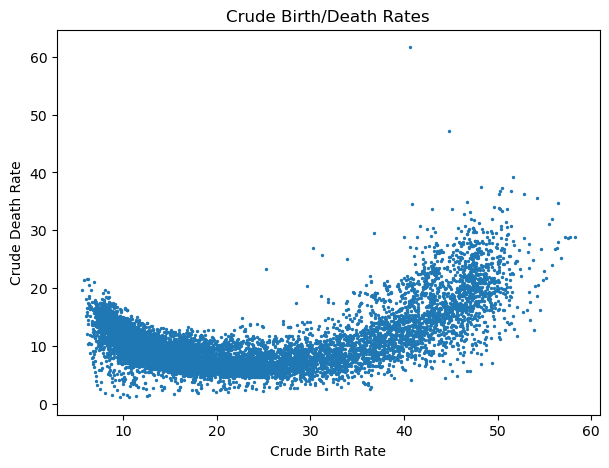

In [9]:
df = pd.read_csv("dataTP2.csv", sep = ",")
df = df[["CBR", "CDR"]]

#------Plot data------#
plt.figure(figsize=(7, 5))
plt.scatter(df["CBR"], df["CDR"], s = 2)
plt.title("Crude Birth/Death Rates")
plt.xlabel("Crude Birth Rate")
plt.ylabel("Crude Death Rate")
plt.show()



Le tracé des données laissent penser qu'un modèle GMM est le bienvenu, avec des clusters nettement marqués, de tailles et de formes différentes. A priori, on en observe 3 à l'oeil nu (gauche, centre et celui à droite assez éparpillé).

In [10]:
X = np.array(df)
#Drop nans
X = X[~np.isnan(X).any(axis=1)]

#Normalisation des données
mean = np.mean(X)
std = np.std(X)
X = (X - mean)/std
print("We have {} samples".format(X.shape[0]))

We have 13290 samples


Dans ce problème, si le nombre de clusters cible est $p$:
- l'estimation du vecteur $\alpha$ laisse $p-1$ degrés de liberté (contrainte d'appartenance au simplexe)
- celui des centroïdes $(\mu_j)_{1 \leq j \leq p} \in (\mathbb{R}^2)^p$ : $2p$ degrés de liberté
- et enfin celui des matrices $(\Sigma_j)_{1 \leq j \leq p}$ : $p \frac{2*3}{2}$ (contrainte de symétrie)

D'où $df(p) = 6p - 1$

In [11]:
def computeBIC(log_likelihood, p, N):
    """
    Args:
        likelihood (float): log-likelihood of the model
        p (int): number of estimated clusters

    Returns
        (float): BIC score of the model
    """
    freedom = p-1 + p*2 + p*2*3/2 #degree of freedom for p clusters, dimension = 2
    return -log_likelihood + 0.5*p*np.log(N)

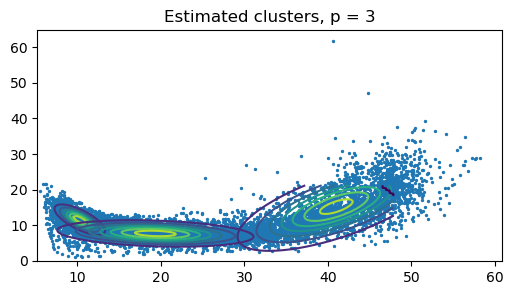

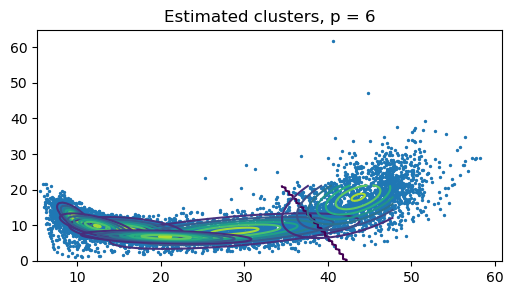

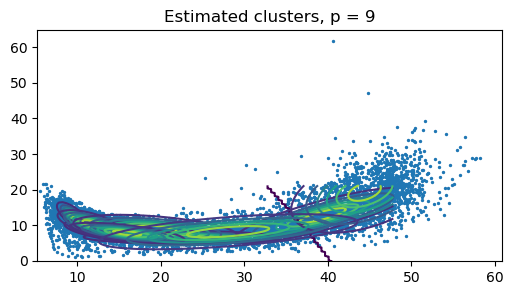

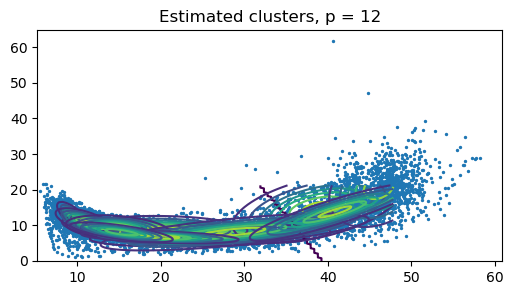

In [12]:
all_bics = []
p_max = 15
ps = range(1, p_max)
for p in ps:
    #------INIT------#
    alphas_init = [1/p]*p 
    mus_init = X[np.random.choice(N, p, replace=False)]
    Sigmas_init = np.zeros((d,d,p))
    for i in range(p):
        Sigmas_init[:,:,i] = np.eye(d)

    #------EM ALGORITHM------#

    log_likelihoods, all_alphas, all_mus, all_Sigmas, all_taus = EM_Algorithm(X, p, alphas_init, mus_init, Sigmas_init, Niter = 40, verbose = False, eps = 1e-1)

    predicted_alphas = all_alphas[-1]
    predicted_mus = all_mus[-1]
    predicted_Sigmas = all_Sigmas[-1]
    predicted_taus = all_taus[-1]

    #------BIC------#
    bic = computeBIC(log_likelihoods[-1], p, X.shape[0])
    all_bics.append(bic)

    #------Plot estimated clusters------#

    if p % 3 ==0: #Pour éviter trop de plots
        fig = plt.figure(figsize=(6, 3))

        # Plot the corresponding p.d.f over the scatter plot with plt.contour
        x = np.linspace(-1, 3, 100)*std + mean
        y = np.linspace(-1.5,0.5, 100) *std + mean
        xx, yy = np.meshgrid(x, y)
        pos = np.empty(xx.shape + (2,))
        pos[:, :, 0] = xx; pos[:, :, 1] = yy
        for k in range(p):
            plt.contour(xx, yy, stats.multivariate_normal.pdf(pos, predicted_mus[k]*std+mean, predicted_Sigmas[:, :, k]*std**2))
        plt.scatter(df["CBR"], df["CDR"], s = 2)
        plt.title("Estimated clusters, p = {}".format(p))
        plt.show()

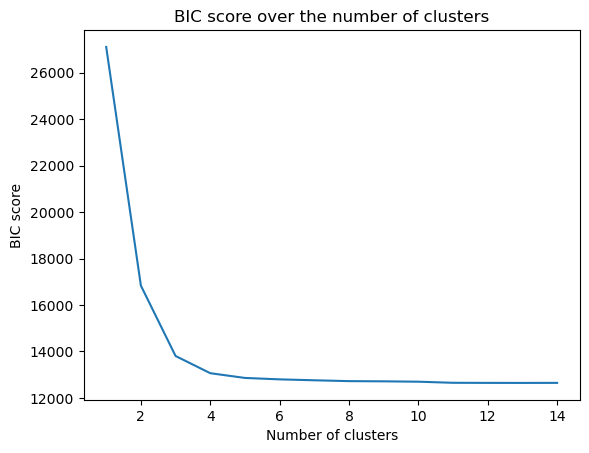

The best number of clusters is 13 with a BIC score of 12646.15635244857


In [13]:
plt.plot(ps, all_bics)
plt.title("BIC score over the number of clusters")
plt.xlabel("Number of clusters")
plt.ylabel("BIC score")
plt.show()

best_p = np.argmin(all_bics) + 1
print("The best number of clusters is {} with a BIC score of {}".format(best_p, all_bics[best_p-1]))

Le nombre optimal de clusters serait dont 13. On remarque nonobstant que le BIC atteint un plateau à environ 6 clusters cibles.

## Exercice 3: Importance Sampling

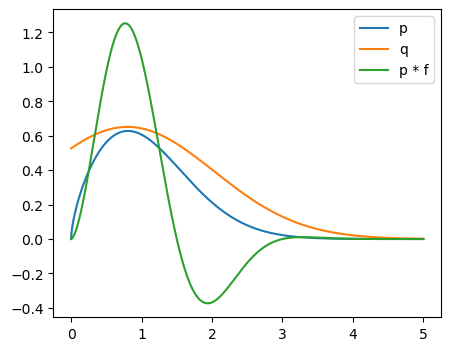

In [22]:
def p(x):
    return (x**0.65) * np.exp(-(x**2)/2)

def f(x):
    return 2*np.sin(2*np.pi*x/3)

def q(x, mu , sigma = 1.5**0.5):
    return 2*stats.norm.pdf(x, loc = mu, scale = sigma)

X= np.linspace(0,5,1000)
plt.figure(figsize=(5, 4))
plt.plot(X, p(X), label = "p")
plt.plot(X, q(X, 0.8), label = "q")
plt.plot(X, p(X)*f(X), label = "p * f")

plt.legend()
plt.show()


On calcule notre estimateur en utilisant des échantillons de taille $N = 10, 100, 10^3, 10^4$. Pour chaque $\mu$, on calcule $n_{iter} = 100$ estimateurs et on prend la moyenne et variance sur ces 100 itérations. 
(Il y a donc au total génération de $N*n_{iter}$  $X_i$ pour un $\mu$ et un $N$ donnés).

In [52]:
def simpleImportanceSampling(mu, N, sigma = 1.5**0.5, n_iter = 100):
    """
    Args:
        p (function): density function of the distribution we want to sample from
        f (function): function we want to integrate
        mu (float): mean of the normal distribution
        sigma (float): standard deviation of the normal distribution
        N (int): number of samples to generate

    Returns
        (array, size n_iter): n_iter estimators of the integral of p*f
        (array, size N, n_iter): all the normalized weights of the samples (omegas)
    """
    X = np.random.normal(loc = mu, scale = sigma, size = (N, n_iter))
    X = X*(X>0) #We only keep the positive values, replacing the negative ones by 0
    omegas = p(X)/q(X, mu) #shape (N, n_iter) ; weights
    omegas = omegas/np.mean(omegas, axis=0) #normalization as p is not normalized
    return np.sum(omegas*f(X), axis=0)/N, omegas
    

---------mu = 0.8-----------
             Mean  Variance
N                          
10.0     0.677506  0.297081
100.0    0.770725  0.022210
1000.0   0.762317  0.002225
10000.0  0.771639  0.000184

---------mu = 6-----------
             Mean  Variance
N                          
10.0     0.282635  1.579154
100.0    0.051228  1.530402
1000.0  -1.038344  0.554184
10000.0 -0.028567  1.032248



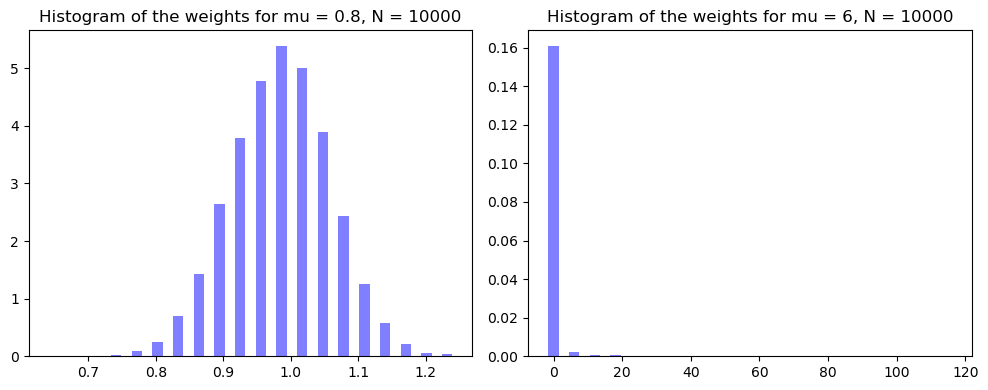

In [70]:
Ns = [10, 100, 1000, 10000]
mus = [0.8, 6]
plt.figure(figsize=(10, 4))
for i, mu in enumerate(mus):
    print("---------mu = {}-----------".format(mu))
    df = pd.DataFrame(columns=["N", "Mean", "Variance"])
    for N in Ns:
        est, weights = simpleImportanceSampling(mu, N)
        weights = np.mean(weights, axis=1) #shape (N,)
        df = df.append({"N": round(N, 0), "Mean": np.mean(est), "Variance": np.var(est)}, ignore_index=True)

    print(df.set_index("N"))
    print("")
    plt.subplot(1,2,i+1)
    plt.hist(weights, density = True, bins = 20, rwidth = 0.5, align = 'left', alpha = 0.5, color = 'b')
    plt.title("Histogram of the weights for mu = {}, N = {}".format(mu, N))

plt.tight_layout()
plt.show()


Pour $\mu = 0.8$, notre estimateur est très précis avec peu de variance et une valeur stable qui semble converger vers 0.77. Au contraire, lorsque $\mu = 6$, l'estimateur est beaucoup plus volatile, la variance sur 100 itérations explose et aucune convergence ne semble se dégager.

On trace l'histogramme des poids  $(\omega_i)_{1\leq i \leq 10^4}$ où chaque coordonnée est moyennée sur les 100 itérations. La différence est claire : pour $\mu = 0.8$, les poids semblent normalisés, centrés en 1. Pour $\mu = 6$, nos poids s'agglutinent autour de 0 ce qui explique les valeurs aberrantes.

En conclusion, l'échantillonnage d'importance naïf est fortement dépendant de la loi $q$ selon laquelle on génère les données : il ne faut pas qu'elle soit trop différente de la loi-cible $p$.